# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση.


## Ομάδα 53
## Μέλη:
  * Αθανασίου Ιωάννης, 03117041
  * Καραβαγγέλης Αθανάσιος, 03117022
  * Τσιτσής Αντώνης, 03117045

## Εγκατάσταση πακέτων

In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

## Εισαγωγή Dataset

In [ ]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1-tN5rC1QCgwqL67cvIXdMbtd-Xf9Xqow"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

import numpy as np

# Ομάδα εργαστηρίου
team_seed_number = 53 

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1-oeMf7BFmiH70XObgC9WOTo-a9cDJZwP"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

## Προεπεξεργασία corpus

### Φέρνω τις βιβλιοθήκες

In [ ]:
import nltk
import string
from nltk import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

### Φιλτράρω το corpus και σχηματίζω το new_corpus

In [ ]:
# fetch stopwords
stopwords = set(nltk.corpus.stopwords.words("english"))

def update_tag(pair):
  '''
  * input: (word, tag)
  * output: (word, new_tag)
  * where new_tag is the tag, but updated to fit with the wordnet_lemmatizer.lemmatize accepted tags
  '''
  word, tag = pair
  # all pos_tag results at: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
  # adjective
  if tag.startswith('J'):
    tag = wordnet.ADJ
  # verb
  elif tag.startswith('V'):
    tag = wordnet.VERB
  # noun
  elif tag.startswith('N'):
    tag = wordnet.NOUN
  # adverb
  elif tag.startswith('R'):
    tag = wordnet.ADV
  else:
    tag = None
  return word, tag
  
  
def my_lemmatize(words):
  '''
  * lemmatize words
  * for example taking -> take
  '''
  wordnet_lemmatizer = WordNetLemmatizer()
  with_tags = pos_tag(words)
  with_tags = list(map(update_tag, with_tags))

  lemmatized = [
      wordnet_lemmatizer.lemmatize(word, tag) if tag
      else wordnet_lemmatizer.lemmatize(word)
      for word, tag in with_tags
  ]
  return lemmatized

def filter_word(word):
  '''
  * to lower case
  * remove punctuation and symbols
  '''
  chars = [char for char in word.lower() if char not in string.punctuation]
  new_word = ''.join(chars)

  return new_word

def filter_description(description):
  '''
  * filter words with `filter_word` AND
  * remove stopwords, non-aplha words (numbers etc...), small words (len<3)
  * lemmatize using `my_lemmatize`
  '''
  words = [filter_word(word) for word in nltk.word_tokenize(description) if word.isalpha() and word.lower() not in stopwords and len(word)>=3] 
  lemmatized = my_lemmatize(words)
  return ' '.join(lemmatized)

new_corpus = list(map(filter_description, corpus))

### Ελέγχω στην πρώτη περιγραφή

In [ ]:
print("Before:", corpus[0])
print("------------------")
print("After:", new_corpus[0])

Before: The film tells the story of Ishwar Chakraborty , a Hindu refugee from East Pakistan after the 1947 partition of India. He goes to West Bengal with his little sister Sita  where he tries to start a new life. In a refugee camp, they see the abduction of a low-caste woman and Ishwar takes her little son Abhiram  with him. He gets a job at a factory in the province, near the river Subarnarekha. After completing his study when Abhiram is asked to go to Germany for his studies, he  and Sita  discover that they are in love. But at this moment, Ishwar's fear of prejudice emerges, as he does not want his sister, a Brahmin, to marry a lower caste boy. During Sita's wedding with another man, the girl and Abhiram elope and go to Calcutta. Ishwar is angry and heartbroken. Sita and Abhiram live in the slums of Calcutta and try to make ends meet. They have a little son . One day, Abhiram gets a new job as a bus driver, but this leads to tragedy: when he accidentally hits and kills a little gi

## Μετατροπή σε TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# create sparse tf_idf representation
vectorizer = TfidfVectorizer(
    analyzer='word',
    # strip_accents = "ascii",          # discart non ascii chars (already done in corpus preprocessing)
    # stop_words='english',             # remove stopwords        (already done in corpus preprocessing)
    min_df=2,                         # discart features with frequency less than x (will probably remove names,locations, maybe important unique words used in sequels of movies)
    max_features=100000               # keep x most frequent features of total
    )                                 

corpus_tf_idf_plain = vectorizer.fit_transform(new_corpus)
joblib.dump(corpus_tf_idf_plain, 'my_corpus.pkl')
feature_names = vectorizer.get_feature_names_out()
print(feature_names)

['aakash' 'aam' 'aaron' ... 'zorro' 'ángel' 'émigré']


In [ ]:
print(corpus_tf_idf_plain.shape)
print(len(new_corpus))

(5000, 19425)
5000


## Υλοποίηση του συστήματος συστάσεων

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
import textwrap
from tabulate import tabulate

def content_recommender(target_movie, max_recommendations, corpus_type, **kwargs):

  cosine_similarities = linear_kernel(corpus_type[target_movie:target_movie+1], corpus_type).flatten()
  related_docs_indices = cosine_similarities.argsort()[:-(max_recommendations+2):-1]

  print("\033[91m-> Movie ID:",target_movie)
  print("-> Movie name:",str(titles[target_movie][0]))
  print("-> Movie categories:", categories[target_movie][0] if categories[target_movie] else "-")
  print("\033[0m-> Initial description:", textwrap.fill(corpus[target_movie]))
  print("-> Editted description:", textwrap.fill(new_corpus[target_movie]))
  
  print(f"\nSummary of top {max_recommendations} recommended movies:", end='\n\n')
  print("{:<8} {:<8} {:<35} {:<60} {:<50} {:<10} ".format('ORDER', 'ID','Name', 'Categories', 'Description', 'Cosine Sim'))
  print('-'*130)

  order = 1
  for k in related_docs_indices:
    if k != target_movie:
      print ("{:<8} {:<8} {:<35} {:<60} {:<50} {:<10} ".format(order, k, titles[k][0], f"{categories[k][0][:50]}...", f"{corpus[k][:40]}...", round(cosine_similarities[k], 5)))
      order += 1
  print('-'*130)
  
  print_choice = kwargs.get('print_choice', None)
  if print_choice:
    for i in related_docs_indices:
      if i != target_movie:
        print("Movie ID:", i)
        print("Movie name:", str(titles[i][0]))
        print("Movie categories:", categories[i])
        print('\/'*50)
        print(textwrap.fill(corpus[i]))
        print('-'*100)
        print('-'*100)

content_recommender(target_movie=474, max_recommendations=10, corpus_type=corpus_tf_idf_plain, print_choice=0)

-> Movie ID: 474
-> Movie name: Life of Pi
-> Movie categories: "Drama",  "Adventure"
-> Initial description: Pi is a 16-year-old boy who is the only person to survive the sinking
of a freighter. He finds himself on a lifeboat with an orangutan,
hyena, a wounded zebra, and a Bengal tiger.
-> Editted description: boy person survive sinking freighter find lifeboat orangutan hyena
wound zebra bengal tiger

Summary of top 10 recommended movies:

ORDER    ID       Name                                Categories                                                   Description                                        Cosine Sim 
----------------------------------------------------------------------------------------------------------------------------------
1        322      Two Brothers                        "Family Film",  "Children's",  "Drama",  "Adventur...        Set in 1920s Thailand, two tigers are se...        0.73267    
2        2214     Burning Bright                      "Thriller",  

## Βελτιστοποίηση του TfidfVectorizer

Δοκιμάζοντας random IDs βρήκαμε κάποιες παρόμοιες ταινίες , δηλαδή με παρόμοια recommendations και θα ελέγξουμε κάποια σενάρια πριν και μετά τη βελτιστοποίηση του TfidfVectorizer για να καταλάβουμε τι επιτυγχάνουμε.

#### Παράδειγμα 1

In [ ]:
#Searching for movies with similar recommendations 
content_recommender(target_movie=2879, max_recommendations=4, corpus_type=corpus_tf_idf_plain, print_choice=0)
content_recommender(target_movie=4240, max_recommendations=4, corpus_type=corpus_tf_idf_plain, print_choice=0)
content_recommender(target_movie=4586, max_recommendations=4, corpus_type=corpus_tf_idf_plain, print_choice=0)
content_recommender(target_movie=361 , max_recommendations=4, corpus_type=corpus_tf_idf_plain, print_choice=0)



-> Movie ID: 2879
-> Movie name: Uncivil War Birds
-> Movie categories: "Short Film",  "Comedy",  "Black-and-white"
-> Initial description: It is the American Civil War, and the Stooges enlist in the service.
Moe and Larry accidentally join the Union Army, while Curly manages to
correctly sign up with the Confederate. Before the error can be
corrected, several Union soldiers order Moe and Larry to lock up their
"prisoner." A few moments later, a Confederate general sees Curly
being released and, upon seeing Moe and Larry, thinks he has captured
two Union soldiers. This mix up goes back and forth several times,
until Moe and Larry finally find Confederate uniforms, only to be
caught in Union army headquarters. They eventually escape by
performing minstrel song-and-dance routine in blackface, with Curly
playing a Mammy-type character and Larry strumming a banjo.
-> Editted description: american civil war stooge enlist service moe larry accidentally join
union army curly manages correctly

Εδώ παρατηρούμε πως οι συγκεκριμένες ταινίες αλληλοϋπάρχουν η μία στης αλλης στα top 3 recommendations βάσει cosine. Αυτό σημαίνει πως έχουμε ένα σύστημα που κάνει σωστά recommendations. Αυτο το επιβεβαιώνει και οι κατηγορίες των προτείνομενων ταινιών στις οποίες υπάρχει μία τουλάχιστον κοινή στις περισσότερες περιπτώσεις (Short Film , Comedy). Παρατηρούμε, τέλος πως οι cosine similiraties δεν είναι και πολύ υψηλές (0.28 - 0.35 στο συγκεκριμένο παράδειγμα).

#### Παράδειγμα 2

In [ ]:
content_recommender(target_movie=2000, max_recommendations=4, corpus_type=corpus_tf_idf_plain, print_choice=0)
content_recommender(target_movie=417, max_recommendations=4, corpus_type=corpus_tf_idf_plain, print_choice=0)
content_recommender(target_movie=4162, max_recommendations=4, corpus_type=corpus_tf_idf_plain, print_choice=0)
content_recommender(target_movie=1648 , max_recommendations=4, corpus_type=corpus_tf_idf_plain, print_choice=0)

-> Movie ID: 2000
-> Movie name: The Warrens of Virginia
-> Movie categories: "Silent film",  "Drama",  "Indie",  "Black-and-white"
-> Initial description: As the American Civil War begins, Ned Burton leaves his Southern love,
Agatha Warren, and joins the Union army. He is later protected and
saved from death by Agatha in spite of her loyalty to the South.
-> Editted description: american civil war begin ned burton leaf southern love agatha warren
join union army later protect save death agatha spite loyalty south

Summary of top 4 recommended movies:

ORDER    ID       Name                                Categories                                                   Description                                        Cosine Sim 
----------------------------------------------------------------------------------------------------------------------------------
1        4162     The Big Bang                        "Thriller",  "Crime Thriller",  "Film noir",  "Mys...         The film starts 

Παρατηρούμε και εδώ πως υπάρχει αλληλένδετη σχέση ανάμεσα στα recommendations των ταινιών και οι κατηγορίες είναι και πάλι κοινές (Crime Fiction, Thriller). Ακόμη βλέπουμε πως έχουμε πιο μεγάλα cosines ειδικά για τις 2 πρώτες προτάσεις από ότι στο 1ο παράδειγμα.

#### Τροποποίηση της TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create sparse tf_idf representation
vectorizer = TfidfVectorizer(
    analyzer='word',
    strip_accents = "ascii",          # discart non ascii chars (already done in corpus preprocessing)
    stop_words='english',             # remove stopwords        (already done in corpus preprocessing)
    max_df=95,       
    min_df=15,                         # discart features with frequency less than x (will probably remove names,locations, maybe important unique words used in sequels of movies)
    max_features=20000               # keep x most frequent features of total
    )                                 

corpus_tf_idf_plain = vectorizer.fit_transform(new_corpus).toarray()
feature_names = vectorizer.get_feature_names_out()
print(feature_names)

['abduct' 'abort' 'abortion' ... 'zone' 'zoo' 'zoom']


* Παρατηρούμε ότι το μέγεθος του διανύσματος tf-idf έχει μειωθεί σημαντικά

In [ ]:
print(corpus_tf_idf_plain.shape)

(5000, 3763)


Ξαναδοκιμάζουμε...

#### Παράδειγμα 1 (μετά τη βελτιστοποίηση)

In [ ]:
content_recommender(target_movie=2879, max_recommendations=10, corpus_type=corpus_tf_idf_plain, print_choice=0)
content_recommender(target_movie=4240, max_recommendations=10, corpus_type=corpus_tf_idf_plain, print_choice=0)
content_recommender(target_movie=4586, max_recommendations=10, corpus_type=corpus_tf_idf_plain, print_choice=0)
content_recommender(target_movie=361, max_recommendations=10, corpus_type=corpus_tf_idf_plain, print_choice=0)

-> Movie ID: 2879
-> Movie name: Uncivil War Birds
-> Movie categories: "Short Film",  "Comedy",  "Black-and-white"
-> Initial description: It is the American Civil War, and the Stooges enlist in the service.
Moe and Larry accidentally join the Union Army, while Curly manages to
correctly sign up with the Confederate. Before the error can be
corrected, several Union soldiers order Moe and Larry to lock up their
"prisoner." A few moments later, a Confederate general sees Curly
being released and, upon seeing Moe and Larry, thinks he has captured
two Union soldiers. This mix up goes back and forth several times,
until Moe and Larry finally find Confederate uniforms, only to be
caught in Union army headquarters. They eventually escape by
performing minstrel song-and-dance routine in blackface, with Curly
playing a Mammy-type character and Larry strumming a banjo.
-> Editted description: american civil war stooge enlist service moe larry accidentally join
union army curly manages correctly

#### Παράδειγμα 2 (μετά τη βελτιστοποίηση)

In [ ]:
content_recommender(target_movie=2003, max_recommendations=10, corpus_type=corpus_tf_idf_plain, print_choice=0)
content_recommender(target_movie=417 , max_recommendations=10, corpus_type=corpus_tf_idf_plain, print_choice=0)
content_recommender(target_movie=4162, max_recommendations=10, corpus_type=corpus_tf_idf_plain, print_choice=0)
content_recommender(target_movie=1648, max_recommendations=10, corpus_type=corpus_tf_idf_plain, print_choice=0)

-> Movie ID: 2003
-> Movie name: 20,000 Leagues Under the Sea
-> Movie categories: "Animation"
-> Initial description: In the year 1866, a mysterious sea-monster is hunting the depths of
the oceans and rising only to attack and destroy innocent ships at a
cost of many lives. Experts around the world are trying to discover
the identity of the monster and possibly destroy it before even more
lives are lost. Marine expert Professor Pierre Aronnax, his faithful
companion Conseil and harpoonist Ned Land, set out aboard the Abraham
Lincoln from Long Island in search of said monster. The monster
attacks, and the three companions are thrown overboard and the ship's
crew declares them lost. Their lives are saved as they are held above
water by the monster, which they discover to be a modern submarine,
named the Nautilus. Inside, they meet the submarine's captain, Captain
Nemo, and his faithful crew. To keep his secret safe, Captain Nemo
keeps the three men aboard his ship. Aboard the Nautilus, 

#### Συμπέρασμα

Μετά την βελτιστοποίηση της TfidfVectorizer μειώθηκε το μέγεθος των Vector Space Models και άρα είναι λογική η αύξηση που βλέπουμε στο cosine similarity. Αυτό σημαίνει πως κάναμε το recommender system μας καλύτερο αφού ελέγχει για ομοιότητα σε μικρότερες διαστάσεις, χωρίς όμως να χάνουμε πληροφορία.

Έπειτα βλέπουμε πως σε ταινίες με μεγαλύτερα Vector Space Models είναι μεγαλύτερη η απόκλιση ανάμεσα στα top 10 cosine similarities τους αφού οι μεγαλύτερες διαστάσεις ρίχνουν το ποσοστό ομοιότητας.

Παρατηρούμε και πάλι πως υπάρχει μεγάλη ομοιότητητα στις κατηγορίες ταινιών που προτείνονται και πως υπάρχουν οι ίδιες ταινίες ως προτεινόμενες σε παρόμοιες ταινίες γεγονός που υποδεικνύει πως το σύστημά μας λειτουργεί ορθά.

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

In [ ]:
#!pip install -U gensim
import gensim.downloader
import warnings
warnings.filterwarnings('ignore')
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
info = gensim.downloader.info()                     # show info about available models/datasets
model = gensim.downloader.load("glove-wiki-gigaword-100")  # download the model and return as object ready for use


[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
embeddings_index={}
for word in model.wv.index2word:
  embeddings_index[word] = model.wv[word]

# Get x-dim dense vector for each of the vocab_rocc
embedding_matrix = np.zeros((vocab_size, embedding_dim)) # to import as weights for Keras Embedding layer
for word, i in wordtoix.items():
  embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        


array([-0.27086  ,  0.044006 , -0.02026  , -0.17395  ,  0.6444   ,
        0.71213  ,  0.3551   ,  0.47138  , -0.29637  ,  0.54427  ,
       -0.72294  , -0.0047612,  0.040611 ,  0.043236 ,  0.29729  ,
        0.10725  ,  0.40156  , -0.53662  ,  0.033382 ,  0.067396 ,
        0.64556  , -0.085523 ,  0.14103  ,  0.094539 ,  0.74947  ,
       -0.194    , -0.68739  , -0.41741  , -0.22807  ,  0.12     ,
       -0.48999  ,  0.80945  ,  0.045138 , -0.11898  ,  0.20161  ,
        0.39276  , -0.20121  ,  0.31354  ,  0.75304  ,  0.25907  ,
       -0.11566  , -0.029319 ,  0.93499  , -0.36067  ,  0.5242   ,
        0.23706  ,  0.52715  ,  0.22869  , -0.51958  , -0.79349  ,
       -0.20368  , -0.50187  ,  0.18748  ,  0.94282  , -0.44834  ,
       -3.6792   ,  0.044183 , -0.26751  ,  2.1997   ,  0.241    ,
       -0.033425 ,  0.69553  , -0.64472  , -0.0072277,  0.89575  ,
        0.20015  ,  0.46493  ,  0.61933  , -0.1066   ,  0.08691  ,
       -0.4623   ,  0.18262  , -0.15849  ,  0.020791 ,  0.1937

Για να κατανοήσουμε τη μορφή για τα embeddings για μία λέξη π.χ. history...

In [ ]:
topn = 100                                    #number of embeddings
w2v = model.wv                                #embeddings vector
print(*w2v["history"])
print("Shape:",corpus.wv["history"].shape)

0.2146 0.73921 0.79858 0.10209 0.10226 0.2875 0.30578 -0.58027 -0.87372 0.095291 -0.31811 -0.033557 0.38705 0.45357 -0.31216 0.18793 1.0856 0.0018788 -0.47521 0.51265 -0.11545 0.39716 0.051649 -0.25856 0.27369 -0.95031 -0.13871 -0.66468 0.16728 -0.57002 -0.74233 0.135 -0.37455 0.13538 -0.74598 -0.44546 -1.2134 0.27005 -0.71595 -0.078459 -0.58639 -0.28859 -0.29752 -0.42066 -0.080466 -0.13753 1.2055 -0.32076 0.21823 -0.44166 0.51726 -0.14649 0.22339 0.82143 0.33366 -2.141 -0.16177 -0.024171 1.6021 0.85862 -0.37618 1.0077 0.11486 -0.50389 1.1086 0.12977 0.49186 0.059207 0.035015 0.25293 0.17822 0.38248 -0.075291 0.47481 -0.18083 -0.32481 -0.11984 0.032416 -1.3414 0.18056 -0.13158 0.53583 0.088885 0.30953 -1.0697 0.20117 -1.0554 -1.1647 0.1156 -0.48444 0.16773 0.18189 -0.16731 0.32984 -0.27731 -0.1274 -0.33503 -0.833 0.16701 0.41966
Shape: (100,)


In [ ]:
print(corpus_tf_idf_plain.shape)
d = vectorizer.vocabulary_
len(d)
print(d)
print(len(d.values()))
print(len(d.keys()))


(5000, 3763)
{'hindu': 1605, 'refugee': 2776, 'east': 1099, 'factory': 1264, 'province': 2654, 'germany': 1451, 'prejudice': 2589, 'lower': 2020, 'elope': 1134, 'heartbroken': 1573, 'tragedy': 3491, 'lynch': 2035, 'prostitution': 2648, 'meantime': 2107, 'lonely': 2002, 'sad': 2948, 'tour': 3476, 'brothel': 437, 'client': 606, 'throat': 3440, 'breaks': 419, 'relative': 2796, 'everybody': 1210, 'excite': 1223, 'performer': 2465, 'coach': 624, 'bicycle': 354, 'greet': 1497, 'sings': 3104, 'jazz': 1836, 'expel': 1239, 'bike': 356, 'tunnel': 3528, 'scuffle': 2995, 'carriage': 509, 'closing': 617, 'sole': 3157, 'merchant': 2126, 'mount': 2212, 'kyle': 1914, 'ashore': 195, 'jungle': 1877, 'sink': 3106, 'duck': 1080, 'preserve': 2595, 'presumably': 2598, 'dare': 858, 'error': 1192, 'extensive': 1256, 'stall': 3219, 'hiding': 1597, 'surrender': 3334, 'obsessed': 2321, 'ram': 2713, 'float': 1348, 'crane': 802, 'friendly': 1405, 'frenchman': 1401, 'louis': 2016, 'dive': 1031, 'mud': 2219, 'doom':

In [ ]:
# vocabulary is the dict: { word: tf_idf's column }
# I will build the inverse dict: { tf_idf's column: word }

inverse_vocabulary = { val: key for [key, val] in vectorizer.vocabulary_.items() }
print(sorted(inverse_vocabulary.items(), key=lambda x: x[0]))

[(0, 'abduct'), (1, 'abort'), (2, 'abortion'), (3, 'abraham'), (4, 'abroad'), (5, 'abruptly'), (6, 'absence'), (7, 'abuse'), (8, 'abused'), (9, 'abusive'), (10, 'academic'), (11, 'academy'), (12, 'accent'), (13, 'acceptance'), (14, 'access'), (15, 'accidental'), (16, 'accompanies'), (17, 'accomplice'), (18, 'accomplish'), (19, 'accord'), (20, 'account'), (21, 'accountant'), (22, 'accusation'), (23, 'accuses'), (24, 'ace'), (25, 'achieve'), (26, 'acid'), (27, 'acknowledge'), (28, 'acquaintance'), (29, 'acquire'), (30, 'activate'), (31, 'active'), (32, 'activist'), (33, 'actress'), (34, 'actual'), (35, 'adam'), (36, 'adamant'), (37, 'adapt'), (38, 'adaptation'), (39, 'add'), (40, 'addict'), (41, 'addiction'), (42, 'addition'), (43, 'additional'), (44, 'address'), (45, 'adjust'), (46, 'administer'), (47, 'admire'), (48, 'admirer'), (49, 'admits'), (50, 'adolf'), (51, 'adoptive'), (52, 'adult'), (53, 'advanced'), (54, 'advantage'), (55, 'advertise'), (56, 'advertising'), (57, 'advise'), (5

In [ ]:
from time import sleep
from tqdm import tqdm
def tfw2v_one_doc(corpus, vectors, embeddings_size, description_index):
  """
  * builds the vector for the movie with index==`description_index` on the corpus
  """
  denominator = corpus[description_index].sum()
  vector_after_embeddings = [0]*embeddings_size
  for index in range(len(corpus[description_index])):
    word = inverse_vocabulary[index]
    tfidf = corpus[description_index][index]
    try:
      word_vector = vectors[word]
      for i in range(embeddings_size):
        vector_after_embeddings[i] += word_vector[i]*tfidf / denominator
    except Exception as e:
      x=1
  return vector_after_embeddings
    

def build_tfw2v(corpus, vectors, embeddings_size):
  """
  * builds the corpus2 array for all the movies
  * calls tfw2v_one_doc for each movie
  """
  d = vectorizer.vocabulary_
  corpus2 = []
  for description_index in tqdm(range(len(corpus)), desc="Loading…", ascii=False, ncols=75):
    descr_vector = tfw2v_one_doc(corpus, vectors, embeddings_size, description_index)
    corpus2.append(descr_vector)
    sleep(0.00000001)
  return corpus2

In [ ]:
corpus2 = build_tfw2v(corpus_tf_idf_plain, w2v, topn)

Loading…: 100%|██████████████████████| 5000/5000 [1:35:05<00:00,  1.14s/it]


In [ ]:
corpus2 = np.array(corpus2)
corpus2.shape

(5000, 100)

In [ ]:
import joblib
joblib.dump(corpus2, 'corpus2-5000-100.pkl')


['corpus2-5000-100.pkl']

In [ ]:
corpus2 = joblib.load('corpus2-5000-100.pkl')

## Ανάλυση Αποτελεσμάτων

### Περιγραφή προεπεξεργάσιας

Για την προεπεξεργασία κάναμε τα εξής: 
* Μετατρέψαμε όλους τους χαρακτήρες σε πεζά γράμματα
* Αφαιρέσαμε τα stopwords με τη βοήθεια της βιβλιοθήκης nltk και των stopwords της γλώσσας english.  
* Αφαιρέσαμε σημεία στίξης και ειδικούς χαρακτήρες.
* Ακόμη αφαιρέσαμε πολυ σύντομες συμβολοσειρές και αριθμητικές συμβολοσειρές.
* Τέλος κάναμε lemmatization με τη βοήθεια του WordNetLemmatizer της nltk.

### Bελτιστοποίηση της TfidfVectorizer

Για τη βελτιστοποίηση της συνάρτησης TfidfVectorizer λάβαμε υπόψιν τόσο τα παραδείγματα random ταινιών με παρόμοια recommendations αλλά και την αντίρροπη κατεύθυνση δηλαδή την αλλαγή των παραμέτρων της συνάρτησης (κυρίως max_df και min_df) έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που άρχισαν να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. Στην ουσία προσαρμόζαμε τις παραμέτρους max_df και min_df βάση τα αποτελέσματα που παίρναμε από την recommender συνάρτηση για διάφορες ταινίες.



### Cherry picking


Στις παρακάτω ταινίες βλέπουμε πως τα recommendations που γίνονται είναι πολύ κοντα στην δοθείσα ταινία αφού οι κατηγορίες ταυτίζονται και συγκεκριμένα στη δεύτερη που αφορά τη σειρά ταινιών "The Stooges" βλέπουμε ότι το σύστημα μας σωστά έχει προτείνει τις υπόλοιπες ταινίες από τη σειρά.

In [ ]:
content_recommender(target_movie=4240, max_recommendations=5, corpus_type=corpus_tf_idf_plain, print_choice=0)
content_recommender(target_movie=4586, max_recommendations=5, corpus_type=corpus_tf_idf_plain, print_choice=0)

-> Movie ID: 4240
-> Movie name: Corny Casanovas
-> Movie categories: "Short Film",  "Comedy",  "Black-and-white",  "Slapstick"
-> Initial description: The Stooges are happily cleaning house, as they dream about getting
married in a few hours. The usual antics occur as the boys make a near
shambles of their home. For starters, Shemp decides to use the wooden
handle of a loaded pistol as a hammer, which of course goes off, and
parts Moe's sugarbowl haircut right down the middle. Then the trio try
to reupholster a davenport, but end up clobbering Moe on several
counts. First, they cut the upholstering with a scissor and end up
trimming Moe's sportcoat. Then, to speed things up, they pour the
upholstering tacks into a machine gun and aim at the davenport. The
rapid fire release works well at first, but Larry and Shemp argue over
who gets the next round, leading the rifle firing right at Moe's
gluteus maximus. After Larry and Shemp quickly remove the tacks, Moe
manages to swallow one. Afte

### Nir Picking

Για τις παρακάτω ταινίες το σύστημα δε δουλεύει σωστά αφού στην πρώτη βλέπουμε ότι λόγω της μικρής περιγραφής και συγκεκριμένα των λέξεων korean και enemy, το σύστημα μας έχει προτείνει ταινίες πολέμου.

Στη 2η ταινία αυτό που προκαλέι το πρόβλημα είναι και πάλι η μικρή περιγραφή αλλά και το όνομα charlie που προκαλεί ύπαρξη μεγάλων cosine similarities λόγω της ύπαρξης αυτού και σε άλλες περιγραφές.

Μια βελτιστοποίηση για το σύστημά μας που παρατηρούμε εδώ θα ήταν μία ειδική μεταχείριση των ονομάτων στην προεπεξεργασία μας. 

In [ ]:
content_recommender(target_movie=6, max_recommendations=5, corpus_type=corpus_tf_idf_plain, print_choice=1)
content_recommender(target_movie=597, max_recommendations=5, corpus_type=corpus_tf_idf_plain, print_choice=1)

-> Movie ID: 6
-> Movie name: Real Fiction
-> Movie categories: "Thriller",  "Crime Thriller",  "Crime Fiction",  "Drama",  "World cinema"
-> Initial description: Real Fiction follows a South Korean artist as he systematically seeks
out, and then guns down his real or imagined enemies.
-> Editted description: real fiction follow south korean artist systematically seek gun real
imagined enemy

Summary of top 5 recommended movies:

ORDER    ID       Name                                Categories                                                   Description                                        Cosine Sim 
----------------------------------------------------------------------------------------------------------------------------------
1        4448     Going All the Way                   "Indie",  "Period piece",  "Drama",  "Comedy",  "F...         Two men return home to Indiana after th...        1.0        
2        3210     Spring In My Hometown               "Drama",  "War film"...  

### Πλεονεκτήματα - Μειονεκτήματα tfidf

**Πλεονεκτήματα** \\
Τα μεγαλύτερα πλεονεκτήματα του tfidf είναι το πόσο απλό και εύκολο είναι να το χρησιμοποιήσεις σαν μέθοδο. Είναι εύκολο στον υπολογισμό και αποτελεί ένα απλό σημείο εκκίνησης για να ελέγξει κανείς την ομοιότητα (όχι μόνο σε ταινίες αλλά γενικά σε διάφορα έγγραφα ή αρχεία).

Όσον αφορά την άσκηση μας βλέπουμε ότι μπορεί σε συνδυασμό με μία καλή προεπεξεργασία να μας δώσει καλές προτάσεις πολύ κοντά σε αυτό που θα ήθελε ένας χρήστης του recommender system.

**Μειονεκτήματα** \\
Το πιο σημαντικό μειονέκτημα του tfidf είναι ίσως ότι δεν μπορεί να αποτυπώσει σημασιολόγια μεταξύ των λέξεων και να αξιολογήσει βάσει αυτής την ομοιότητα. Αυτό ίσως ήταν και το "πλήγμα" στα παραδείγματα που δώσαμε στο nir picking.

Επίσης το tfidf αγνοεί τη σειρά των λέξεων και έτσι σύνθετες λέξεις φράσεις όπως π.χ. man of steel χάνουν το νόημα τους και δε θεωρούνται ως μονάδα στο λεξικό μας. 

## Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec


### Σύγκριση αποτελεσμάτων σε σχέση με το tfidf

Παρατηρούμε πως η υλοποίηση μας για το corpus με word2vec δεν έχει αντίστοιχα καλές επιδόσεις με αυτό του tfidf. Βλέπουμε πως για τα παρακάτω παραδείγματα , που ήταν στο cherry picking του tfidf, οι ταινίες που προτείνονται μπορεί ναι μεν να έχουν κάποιες κοινές κατηγορίες αλλά δεν είναι "κοντά" νοηματικά με τις ταινίες εισόδου. 

Βλέπουμε επίσης πως υπάρχει η τάση να προτείνονται ταινίες με περιγραφή που είναι σχετικά μικρού μεγέθους. 

Για τις ταινίες που είχαμε nir picking στο tfidf παρατηρούμε πως σε εκείνη με τη λέξη charlie το word2vec κατάφερε να προβλέψει κάποιες ίδιας κατηγορίας.Για την ταινία με id:6, με τη λέξη korean αντιμετωπίζει το ίδιο θέμα με το tfidf.

In [ ]:
# cherry picking tfidf
content_recommender(target_movie=4240, max_recommendations=5, corpus_type=corpus2, print_choice=1)
content_recommender(target_movie=4586, max_recommendations=5, corpus_type=corpus2, print_choice=1)

# nir picking tfidf
content_recommender(target_movie=6, max_recommendations=5, corpus_type=corpus_tf_idf_plain, print_choice=1)
content_recommender(target_movie=597, max_recommendations=5, corpus_type=corpus_tf_idf_plain, print_choice=1)

-> Movie ID: 4240
-> Movie name: Corny Casanovas
-> Movie categories: "Short Film",  "Comedy",  "Black-and-white",  "Slapstick"
-> Initial description: The Stooges are happily cleaning house, as they dream about getting
married in a few hours. The usual antics occur as the boys make a near
shambles of their home. For starters, Shemp decides to use the wooden
handle of a loaded pistol as a hammer, which of course goes off, and
parts Moe's sugarbowl haircut right down the middle. Then the trio try
to reupholster a davenport, but end up clobbering Moe on several
counts. First, they cut the upholstering with a scissor and end up
trimming Moe's sportcoat. Then, to speed things up, they pour the
upholstering tacks into a machine gun and aim at the davenport. The
rapid fire release works well at first, but Larry and Shemp argue over
who gets the next round, leading the rifle firing right at Moe's
gluteus maximus. After Larry and Shemp quickly remove the tacks, Moe
manages to swallow one. Afte

Μία ταινία για την οποία δουλεύει καλά το σύστημα μας θα ήταν η παρακάτω όπου οι προτεινόμενες ταινίες είναι κοντά όσον αφορά τις κατηγορίες και γενικά πρόκειται για ταινίες drama όπως η δοθείσα.

In [ ]:
content_recommender(target_movie=3500, max_recommendations=5, corpus_type=corpus2, print_choice=1)

-> Movie ID: 3500
-> Movie name: Persuasion
-> Movie categories: "Costume drama",  "Period piece",  "Drama",  "Film adaptation",  "Romantic drama",  "Romance Film"
-> Initial description: The film opens between scenes cutting back and forth of a naval ship
carrying Admiral Croft , and a buggy carrying Mr. Shepherd  and his
daughter Mrs. Clay  to Kellynch Hall. Shepherd and Clay are accosted
for debts owed by the residence's owner, Sir Walter Elliot , while
Croft discusses the end of the Napoleonic Wars with fellow navy men.
Sir Walter, a vain foppish baronet, is faced with financial ruin
unless he retrenches. Though he initially opposes the idea, he
eventually agrees to plans to temporarily move to Bath while the hall
is let; this was thought of by Shepherd, family friend Lady Russell ,
and Sir Walter's second eldest, intelligent daughter Anne . Anne is
visibly upset after learning that the new tenant of Kellynch Hall will
be the admiral, who is the brother-in-law of Captain Frederick


Στις γενικές παρατηρήσεις θα ήταν σίγουρα ο χρόνος συγκρότησης του corpus με word2vec που ήταν περίπου 1,5 ώρα όπως φαίνεται και στο αντίστοιχο κελί εκτέλεσης. 

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [ ]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    if isinstance(mycorpus, np.ndarray):
      dense_tf_idf = mycorpus[0:doc_limit,:]
    else:  
      dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [ ]:
final_set = build_final_set(corpus_tf_idf_plain)

In [ ]:
final_set.shape

(5000, 4085)

## Εκπαίδευση χάρτη SOM

### Εισάγω πακέτα

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [ ]:
!pip install --upgrade somoclu


In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade scikit-learn

In [ ]:
# import sompoclu, matplotlib
import somoclu
import numpy as np
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

### Αρχικοποίηση και εκπαίδευση του SOM

Θα χρησιμοποιήσουμε το corpus που προήλθε έπειτα από τη βελτιστοποίηση του tfidf.

In [ ]:
def init_train(n_rows=10, n_columns=10, epochs=50):
  print(f"Initializing som with n_rows={n_rows}, n_columns={n_columns}") 
  som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
  print(f"Training with {epochs} epochs")
  %time som.train(final_set, epochs)
  return som

som = init_train()
joblib.dump(som, 'my_som.pkl')

Initializing som with n_rows=10, n_columns=10
Training with 50 epochs
CPU times: user 4min 49s, sys: 1.19 s, total: 4min 51s
Wall time: 2min 31s


['my_som.pkl']


## Best matching units

* Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία.
* Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. 
* **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**.
* Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.

#### Αποθηκεύω τις παραλλαγές των bmus

In [ ]:
def som_bmus(som, n_rows=10, n_columns=10):
  bmus = som.bmus
  unique_bmus, indices = np.unique(bmus, return_inverse=True, axis=0)
  diff = n_rows*n_columns-1-unique_bmus.shape[0]
  if not diff:
    print("All neurons have at least one movie.")
  else:
    print(f"There are {diff} neurons without a movie.")
  return bmus, unique_bmus, indices

bmus, unique_bmus, indices = som_bmus(som)

There are 6 neurons without a movie.


#### Παρατηρήσεις

* Τα bmus που υπολογίστηκαν για κάθε ταινία:

In [ ]:
print("BMUS:")
print("Shape:", bmus.shape)
print("Values:", bmus, sep='\n')

BMUS:
Shape: (5000, 2)
Values:
[[10 23]
 [ 0  9]
 [16 24]
 ...
 [22 24]
 [24 21]
 [ 0  9]]


* Τα μοναδικά BMUs, αντεσραμμένα ώστε να τηρείται η σύμβαση [γραμμή, στήλη]:

In [ ]:
print("Unique BMUs:")
print("Shape:", unique_bmus.shape)
print("First 5 values:", unique_bmus[:5], "...", sep='\n')


Unique BMUs:
Shape: (496, 2)
First 5 values:
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]]
...


* Το BMU στο οποίο ανήκει κάθε δείγμα (ο neuron στον οποίο αντιστοιχίζεται κάθε ταινία):

In [ ]:
print("Shape:", indices.shape)
print(indices)

Shape: (5000,)
[214   8 329 ... 452 492   8]



## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [ ]:
from sklearn.cluster import KMeans

def cluster_som(som, k=20):
  print(f"Running k-means with clusters_num={k}")
  algorithm = KMeans(n_clusters=k)
  som.cluster(algorithm=algorithm)

In [ ]:
cluster_som(som)
print("Clusters:", som.clusters, sep='\n')


Running k-means with clusters_num=20
Clusters:
[[ 1  1  1  7  5  5  5  9  9  8]
 [ 1  1  7  7  7  5  5  9  8  8]
 [12  7  7  7  7 15 15  3  8  8]
 [12 12  7  7  7 15 15  3  0  0]
 [12 12 14 19 19 15 15  3  3  0]
 [10 10 10 19 19  4  4 11 11 11]
 [10 10 10 10 18 18  4 11 11 11]
 [10 10 10 16  2 18  6  6 11 11]
 [14 10 17 17  2  2  6  6 13 13]
 [14 14 17 17  2  2  6  6 13 13]]



## Αποθήκευση του SOM



Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.

* Ορίζω μία συνάρτηση που εκτελεί όλες τις προηγούμενες ενέργειες, ώστε να μπορώ να κατασκευάζω γρήγορα νέα SOM με διαφορετικές τιμές για τα `n_rows`, `n_columns`, `clusters_num` και να τα αποθηκεύω με το joblib

In [ ]:
def create_som(n_rows, n_columns, clusters_num, epochs):
  global som, bmus, unique_bmus, indices
  som = init_train(n_rows, n_columns)
  bmus, unique_bmus, indices = som_bmus(som, n_rows, n_columns)
  cluster_som(som, k=clusters_num)

* Εκτελώντας αυτό το κελί, αλλάζοντας τις παραμέτρους n_rows, n_columns και clusters_num, παράγονται νέα SOM τα οποία αποθηκεύονται με όνομα αρχείου `som-{n_rows}-{n_columns}-{clusters_num}.pkl`.

In [ ]:
import joblib
def create_and_save_som(n_rows=10, n_columns=10, clusters_num=20, epochs=20):
  print("Creating SOM...", end=' ')
  create_som(n_rows, n_columns, clusters_num, epochs) 
  print("OK")
  print("Saving SOM...", end=' ')
  filename = f"som-{n_rows}-{n_columns}-{clusters_num}.pkl"
  joblib.dump(som, filename)
  print("OK")

* Εκτελώντας αυτό το κελί, φορτώνω το αντίστοιχο SOM 

In [ ]:
def load_som(n_rows=10, n_columns=10, clusters_num=20):
  print("Loading SOM...", end=' ')
  filename = f"som-{n_rows}-{n_columns}-{clusters_num}.pkl"
  global som
  som = joblib.load(filename)
  print("OK")
  bmus, unique_bmus, indices = som_bmus(som, n_rows, n_columns)
  # som.clusters is not saved with joblib
  # so, we re-run k-means after loading the som 
  cluster_som(som, k=clusters_num)



## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters



Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">

#### Εκτύπωση του Umatrix

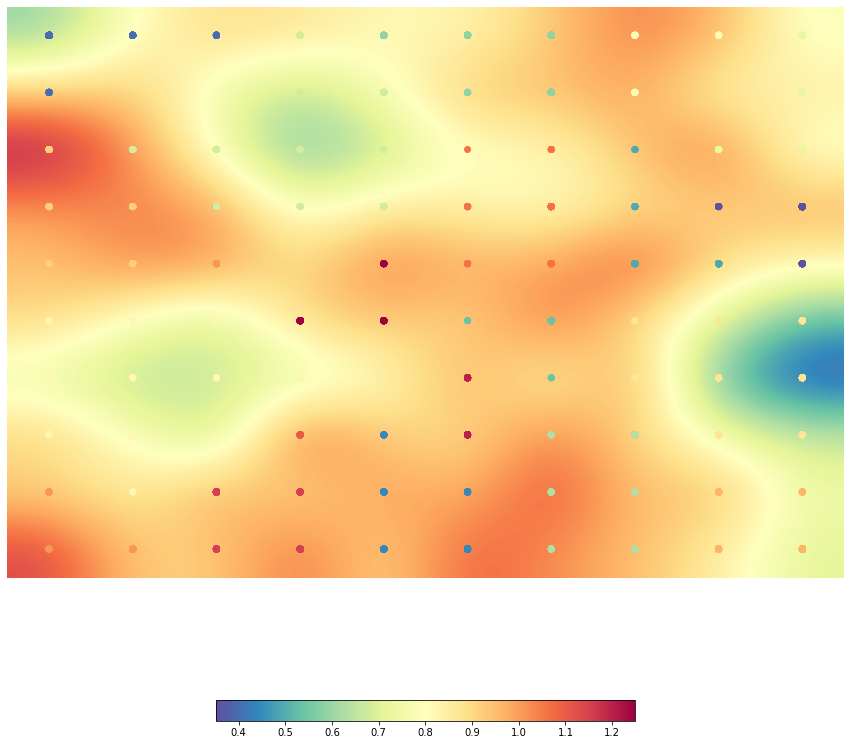

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

#### Τα clusters

* Ο πίνακας som.clusters, δείχνει, για κάθε neuron, σε ποιο cluster αντιστοιχήθηκε. 

In [ ]:
print(som.clusters)

[[ 1  1  1  7  5  5  5  9  9  8]
 [ 1  1  7  7  7  5  5  9  8  8]
 [12  7  7  7  7 15 15  3  8  8]
 [12 12  7  7  7 15 15  3  0  0]
 [12 12 14 19 19 15 15  3  3  0]
 [10 10 10 19 19  4  4 11 11 11]
 [10 10 10 10 18 18  4 11 11 11]
 [10 10 10 16  2 18  6  6 11 11]
 [14 10 17 17  2  2  6  6 13 13]
 [14 14 17 17  2  2  6  6 13 13]]


#### Τα clusters σε φθίνουσα σειρά ως προς τον αριθμό των νευρώνων

In [ ]:
# list of tuples: (cluster_index, number_of_neurons_in_this_cluster)
occurencies = list(enumerate(np.bincount(som.clusters.ravel())))
occurencies.sort(key=lambda pair: pair[1], reverse=True)
print("Cluster \t| #neurons")
print("------------------------")
for pair in occurencies:
  print(f"{pair[0]} \t\t| {pair[1]}")

Cluster 	| #neurons
------------------------
7 		| 11
10 		| 11
11 		| 8
6 		| 6
15 		| 6
1 		| 5
2 		| 5
5 		| 5
8 		| 5
12 		| 5
3 		| 4
13 		| 4
14 		| 4
17 		| 4
19 		| 4
0 		| 3
4 		| 3
9 		| 3
18 		| 3
16 		| 1



## Σημασιολογική ερμηνεία των clusters

   

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο:
* Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) `cluster`.
  * Για το cluster αυτό βρίσκουμε όλους τους `νευρώνες` που του έχουν ανατεθεί από τον k-Means.
    * Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις `ταινίες` που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus).
      * Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη `συνολική στατιστική` όλων των ειδών (κατηγοριών) και τις συχνότητές τους.

  * Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες.
  * Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.



Βήματα:




### 1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών.
  * Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών.
  * Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής:
    * δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`.
    * Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`.  
    * Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`.
  * Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. 
  * Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

In [ ]:
def retrieve_categories_from_str(cats):
  if isinstance(cats, np.ndarray):
    cats = cats[0].split(",")
    cats = list(map(lambda cat: cat.replace('"', "").strip(), cats))
    return cats
  return []

def print_categories_stats(movies_ids):
  """
  [ movies_ids ] -> [ (category1, number_of_movies), (category2, _number_of_movies) ]
  """
  categories_temp = []
  for movie_id in movies_ids:
    cats_str = categories[movie_id]
    cats = retrieve_categories_from_str(cats_str)
    categories_temp.extend(cats)
  values, counts = np.unique(categories_temp, return_counts=True)
  res = list(zip(values, counts))
  res.sort(key=lambda pair: pair[1], reverse=True)
  return(res)

In [ ]:
# test for the first 20 movies...
print(print_categories_stats([i for i in range(20)]))

[('Drama', 11), ('Action', 5), ('Thriller', 5), ('Comedy', 4), ('War film', 4), ('World cinema', 4), ('Action/Adventure', 3), ('Crime Fiction', 3), ('Crime Thriller', 3), ('Animation', 2), ('Biopic [feature]', 2), ('Coming of age', 2), ('Film adaptation', 2), ('Horror', 2), ('Musical', 2), ('Romance Film', 2), ('Action Thrillers', 1), ('Biographical film', 1), ('Biography', 1), ('Black-and-white', 1), ('Bollywood', 1), ("Children's/Family", 1), ('Chinese Movies', 1), ('Christian film', 1), ('Comedy-drama', 1), ('Crime Comedy', 1), ('Fantasy', 1), ('Fantasy Adventure', 1), ('Film noir', 1), ('Hagiography', 1), ('Heist', 1), ('Historical drama', 1), ('Indie', 1), ('Japanese Movies', 1), ('Martial Arts Film', 1), ('Musical Drama', 1), ('Mystery', 1), ('Parody', 1), ('Period piece', 1), ('Romantic comedy', 1), ('Romantic fantasy', 1), ('Science Fiction', 1), ('Short Film', 1), ('Slapstick', 1), ('Tokusatsu', 1)]



### 2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster.
* Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster.
* Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus.
* Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα.
* Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`.
* Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.


In [ ]:
import math

def neuron_index_1d_to_2d_reversed(k, n_cols):
  i = math.floor(k/n_cols)
  j = k%n_cols
  return [j, i]

def neuron_index_2d_to_1d(i, j, n_cols):
  k = i*n_cols + j
  return k

def print_cluster_neurons_movies_report(cluster_index, n_columns=10):
  """
  cluster_index -> [ neurons_ids ]
  """
  print(f"Cluster {cluster_index}:")

  # find all the neurons of the cluster
  neurons_clusters = list(enumerate(som.clusters.ravel()))
  neurons = set(neuron for neuron, cluster in neurons_clusters if cluster == cluster_index)
  init_len = len(neurons)
  print("All neurons: ", neurons)

  bmus_temp = [neuron_index_1d_to_2d_reversed(neuron, n_columns) for neuron in neurons]
  # print("Their bmus:", bmus_temp)
  
  # filter neurons and keep those with bmus in unique bmus
  unique_mbus_list = unique_bmus.tolist()
  for bmu in bmus_temp:
    reversed = [bmu[1], bmu[0]]

    if reversed not in unique_mbus_list:
      neuron_index = neuron_index_2d_to_1d(reversed[0], reversed[1], n_columns)
      # print(f"Removing {bmu} (neuron {neuron_index})")
      neurons.remove(neuron_index)

  print("Kept neurons:", neurons)
  print(f"Kept {len(neurons)}/{init_len} neurons")
  return neurons


Ένα παράδειγμα για ένα cluster με id = 3.


In [ ]:
print_cluster_neurons_movies_report(10)

Cluster 10:
All neurons:  {70, 71, 72, 81, 50, 51, 52, 60, 61, 62, 63}
Kept neurons: {70, 71, 72, 81, 50, 51, 52, 60, 61, 62}
Kept 10/11 neurons


{50, 51, 52, 60, 61, 62, 70, 71, 72, 81}

### 3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`.
* Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες.
* Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

* Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει.
* Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.


In [ ]:
def neuron_movies_report(neurons_ids):
  # find the movies of these neurons
  movies_neurons = list(enumerate(indices))
  movies = [ movie for movie, neuron in movies_neurons if neuron in neurons_ids ]
  print("Overall Cluster Genres stats:")
  return print_categories_stats(movies)


In [ ]:
neuron_movies_report({70, 71, 72, 81, 50, 51, 52, 60, 61, 62})

Overall Cluster Genres stats:
[('Horror', 28), ('Action', 27), ('Thriller', 26), ('Slasher', 23), ('Action/Adventure', 20), ('Animation', 19), ('Comedy film', 16), ('Short Film', 16), ('Family Film', 15), ('Mystery', 14), ('Western', 14), ('Crime Fiction', 10), ('Psychological thriller', 10), ('Indie', 6), ('Crime Thriller', 5), ('Cult', 5), ('Science Fiction', 5), ('Teen', 5), ('Comedy', 4), ('Supernatural', 4), ('World cinema', 4), ('Anime', 3), ('B-movie', 3), ('Suspense', 3), ('Biopic [feature]', 2), ('Black comedy', 2), ('Black-and-white', 2), ('Blaxploitation', 2), ('Drama', 2), ('Epic Western', 2), ('Fantasy', 2), ('Horror Comedy', 2), ('Revisionist Western', 2), ('Biography', 1), ('Costume drama', 1), ('Detective', 1), ('Disaster', 1), ('Docudrama', 1), ('Documentary', 1), ('Ensemble Film', 1), ('Fantasy Adventure', 1), ('Giallo', 1), ('Japanese Movies', 1), ('Media Satire', 1), ('Musical', 1), ('Natural horror films', 1), ('Parody', 1), ('Psycho-biddy', 1), ('Romance Film', 1)

### Έλεγχος
* Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 
* Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```

In [ ]:
def check_som(clusters_num, n_columns):
  som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))
  for cluster_index in range(clusters_num):
    neurons = print_cluster_neurons_movies_report(cluster_index, n_columns)
    neuron_movies_report(neurons)
    print("----------------------------------------")

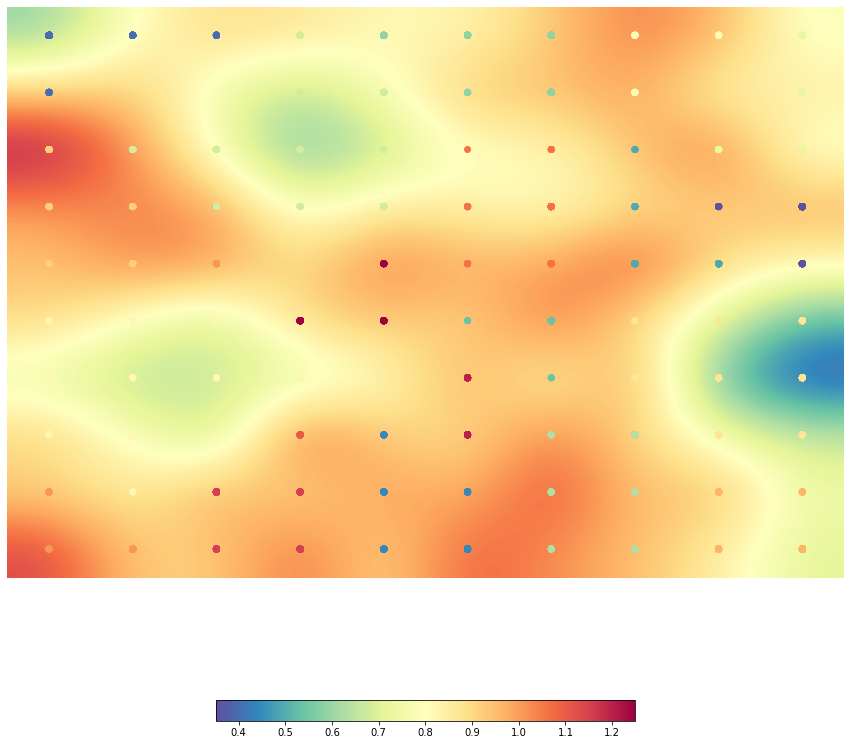

Cluster 0:
All neurons:  {49, 38, 39}
Kept neurons: {49, 38, 39}
Kept 3/3 neurons
Overall Cluster Genres stats:
[('Cult', 11), ('Action', 9), ('Horror', 9), ('Science Fiction', 9), ('Slasher', 8), ('Thriller', 3), ('World cinema', 3), ('Animation', 2), ('Road-Horror', 2), ('Action/Adventure', 1), ('Black comedy', 1), ('Comedy', 1), ('Creature Film', 1), ('Cyberpunk', 1), ('Drama', 1), ('Dystopia', 1), ('Fantasy', 1), ('Indie', 1), ('Japanese Movies', 1), ('Monster', 1), ('Monster movie', 1), ('Mystery', 1), ('Psychological thriller', 1), ('Short Film', 1), ('Stop motion', 1), ('Superhero', 1), ('Superhero movie', 1), ('Teen', 1), ('Television movie', 1)]
----------------------------------------
Cluster 1:
All neurons:  {0, 1, 2, 10, 11}
Kept neurons: {0, 1, 2, 10, 11}
Kept 5/5 neurons
Overall Cluster Genres stats:
[('Short Film', 85), ('Thriller', 65), ('Action', 64), ('Action/Adventure', 64), ('Crime Fiction', 39), ('Crime Thriller', 29), ('Drama', 27), ('Comedy', 15), ('Indie', 12), 

In [ ]:
check_som(clusters_num=20, n_columns=10)

## Δοκιμές διαφορετικών τιμών για τα n_rows, n_columns_, clusters_num


#### Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.


#### Αξιοποιώντας τις συναρτήσεις `create_and_save_som`, `load_som` και `check_som`, μπορώ τώρα να δοκιμάζω διαφορετικές τιμές παραμέτρων:

#### Grid 20x20, 20 Clusters, 30 Epochs

Creating SOM... Initializing som with n_rows=20, n_columns=20
Training with 50 epochs
CPU times: user 19min 51s, sys: 4.68 s, total: 19min 56s
Wall time: 10min 8s
There are 64 neurons without a movie.
Running k-means with clusters_num=20
OK
Saving SOM... OK
Loading SOM... OK
There are 64 neurons without a movie.
Running k-means with clusters_num=20


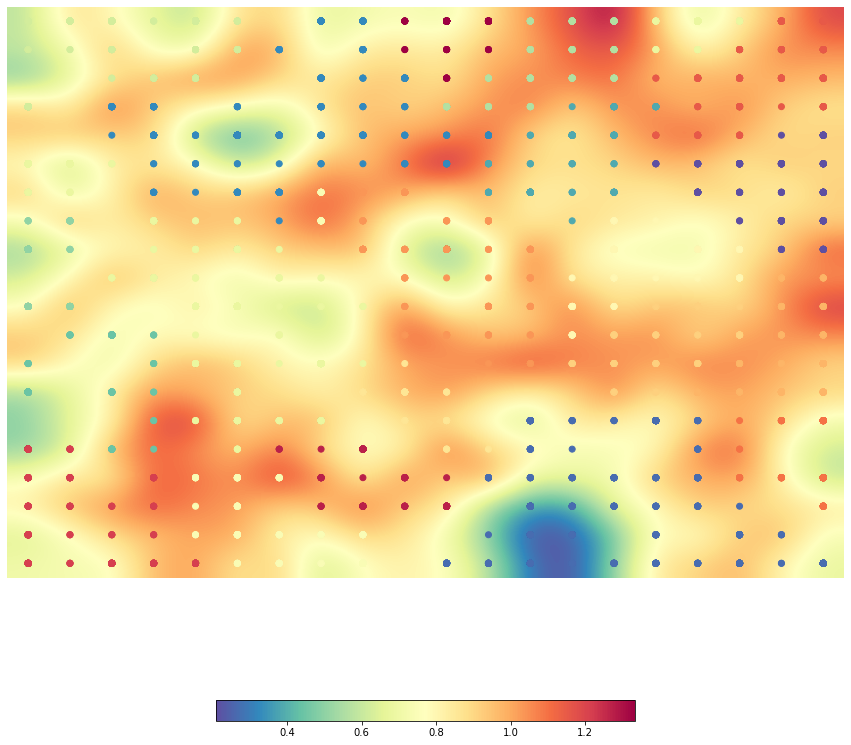

Cluster 0:
All neurons:  {98, 99, 135, 136, 137, 138, 139, 178, 115, 116, 117, 118, 119, 179, 157, 158, 159}
Kept neurons: {98, 99, 135, 136, 138, 139, 178, 115, 116, 117, 118, 119, 179, 157, 158, 159}
Kept 16/17 neurons
Overall Cluster Genres stats:
[('Black-and-white', 82), ('Comedy', 68), ('Drama', 67), ('Family Film', 64), ('Animation', 60), ('Short Film', 55), ('Silent film', 47), ('World cinema', 25), ('War film', 18), ('Horror', 15), ('Science Fiction', 15), ('Adventure', 12), ('Art film', 12), ('Biographical film', 12), ('Comedy-drama', 11), ('Musical', 11), ('Film noir', 8), ('B-movie', 7), ('Costume drama', 7), ('History', 7), ('Biopic [feature]', 6), ('Fantasy', 6), ('Historical fiction', 6), ('Melodrama', 6), ('Period piece', 6), ('Action', 5), ('Biography', 5), ('Coming of age', 5), ('Crime Fiction', 5), ('Mystery', 5), ('Filipino Movies', 4), ('Film adaptation', 4), ('Historical drama', 4), ('Japanese Movies', 4), ('Psychological thriller', 4), ('Romance Film', 4), ('Roma

In [ ]:
n_rows = 20
n_columns = 20
clusters_num = 20
epochs = 30

create_and_save_som(n_rows, n_columns, clusters_num, epochs)
load_som(n_rows, n_columns, clusters_num)
check_som(clusters_num, n_columns)

In [ ]:
import joblib
som_202020 = joblib.load('som-20-20-20.pkl')
print(som_202020.clusters)

[[19 19 19 19 19 19  0  0 11 11 11 11 11  3  3  3  3  3 10 10]
 [19 19 19 19 19 19  0  0  0 11 11 11 11  3  3  3  3 10 10 10]
 [19 19 19 16 16 16  0  0  0  0 11 11  3  3  3  3  3 10 10 10]
 [19 19  0  0  0  0  0  0  0  0  0  0 12 12 12  3 10 10 10 10]
 [18 18  0  0  0  0  0  0  0  0  0  0 12 12 12  3 10 10  5  5]
 [18 18 18  0  0  0  0  0  0  0  0 12 12 12 12  5  5  5  5  5]
 [18 18 18  0  0  0  0  0  0 14 14 12 12 12  2  2  5  5  5  5]
 [ 8  8  8 18 18 18  0  0 14 14 14 14 14  2  2  2  2  5  5  5]
 [ 8  8 18 18 18 18 18 14 14 14 14 14 14  2  2  2  2  2  5  5]
 [ 8  8 18 18 18 18 18 18 14 14 14 14 14  2  2  2  2  2  4  4]
 [ 8  8 15 18 18 18 18 18 18 14 14 14 14  2  2  2  2  4  4  4]
 [ 8 15 15 15 18 18 18 18 18 14 14 14 14  2  2  2  4  4  4  4]
 [15 15 15 15 18 18 18 18  9  9 14 14 14  6  6  6  6  4  4  4]
 [15 15 15 15 18 13 13  9  9  9  9 16 16 16  6  6  6  6  6  6]
 [15 15 15 15 13 13 13  9  9  9  9 16 16 16  6  6  6  6  6  6]
 [ 7  7 15 15 13 13 13  9  9  9  9 16 16 16 17  6  6  6

Αριθμός νευρώνων ανά cluster

In [ ]:
occurencies = list(enumerate(np.bincount(som_202020.clusters.ravel())))
occurencies.sort(key=lambda pair: pair[1], reverse=True)
print("Cluster \t| #neurons")
print("------------------------")
for pair in occurencies:
  print(f"{pair[0]} \t\t| {pair[1]}")

Cluster 	| #neurons
------------------------
17 		| 46
0 		| 45
18 		| 38
14 		| 29
2 		| 23
6 		| 21
1 		| 18
7 		| 18
15 		| 18
19 		| 17
3 		| 16
5 		| 16
9 		| 14
10 		| 14
12 		| 13
4 		| 12
16 		| 12
11 		| 11
8 		| 10
13 		| 9


#### Grid 25x25, 20 Clusters, 50 Epochs

Creating SOM... Initializing som with n_rows=25, n_columns=25
Training with 50 epochs
CPU times: user 31min 20s, sys: 6.47 s, total: 31min 27s
Wall time: 16min 7s
There are 113 neurons without a movie.
Running k-means with clusters_num=20
OK
Saving SOM... OK
Loading SOM... OK
There are 113 neurons without a movie.
Running k-means with clusters_num=20


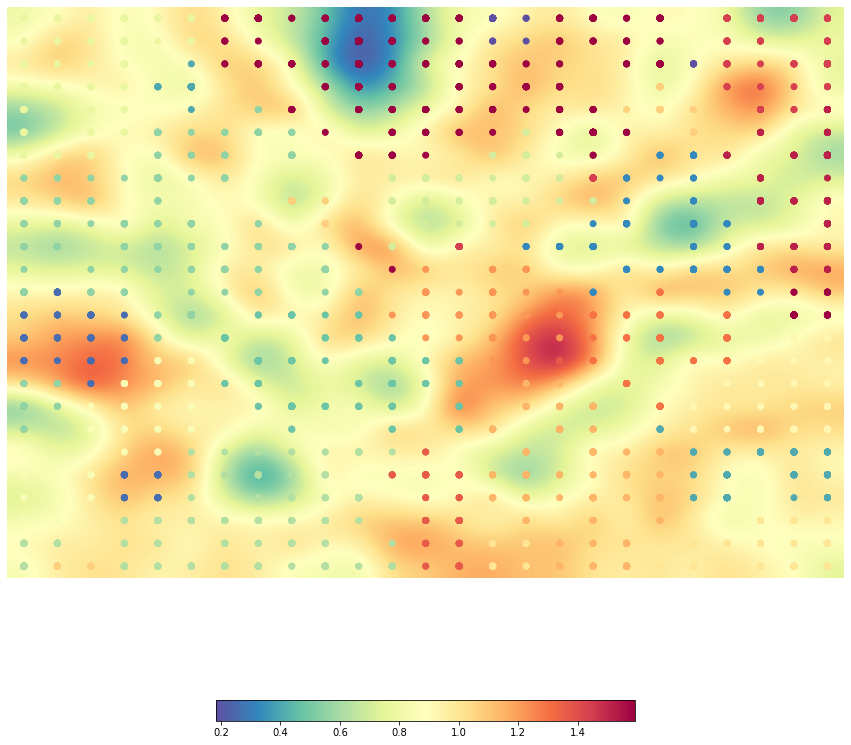

Cluster 0:
All neurons:  {70, 39, 40, 45, 14, 15}
Kept neurons: {70, 39, 40, 45, 14, 15}
Kept 6/6 neurons
Overall Cluster Genres stats:
[('Family Film', 33), ('Animation', 29), ('Short Film', 21), ('Adventure', 16), ("Children's", 12), ("Children's/Family", 11), ('Family-Oriented Adventure', 10), ('Horror', 10), ('Mystery', 8), ('Slasher', 7), ('Thriller', 7), ('Fantasy', 6), ('Animated cartoon', 4), ('Crime Fiction', 4), ('Science Fiction', 3), ('Action', 2), ('Action/Adventure', 2), ('Alien Film', 2), ('Animal Picture', 2), ('Anime', 2), ("Children's Fantasy", 2), ('Drama', 2), ('Fantasy Adventure', 2), ('Japanese Movies', 2), ('Music', 2), ('Romance Film', 2), ('Action Comedy', 1), ('B-movie', 1), ('Black-and-white', 1), ('Coming of age', 1), ('Creature Film', 1), ('Cult', 1), ('Giallo', 1), ('Holiday Film', 1), ('Stop motion', 1), ('Superhero movie', 1), ('Supernatural', 1), ('Teen', 1), ('Whodunit', 1), ('World cinema', 1)]
----------------------------------------
Cluster 1:
All n

In [ ]:
n_rows = 25
n_columns = 25
clusters_num = 20
epochs = 50

create_and_save_som(n_rows, n_columns, clusters_num, epochs)
load_som(n_rows, n_columns, clusters_num)
check_som(clusters_num, n_columns)

In [ ]:
import joblib
som_252520 = joblib.load('som-25-25-20.pkl')
print(som_252520.clusters)

[[12 12 18 18 18 18  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 10 10 10
  10]
 [12 12 18 18 18 18  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 10 10 10
  10]
 [12 12 12 18 18 18  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 10 10 10
  10]
 [12 12 12 12 18 18 18  5  5  5  5  5  5  5  5  5  5  5  0  0  0 10 10 10
  10]
 [12 12 12 12  4 18  4  4  5  5  5  5  5  5  5  5  5  5  0  0  0 10 10 10
  10]
 [12 12 12 12  4  4  4  4  4  5  5  5  5  5  5  1  5  5  5  0  0  7  7  7
   7]
 [12 12 12 12  4  4  4  4  4  4  0  5  5  1  1  1  1  5  5  7  7  7  7  7
   7]
 [ 4  4  4  4  4  4  4  4  4  0  5  1  1  1  1  1  1 10  7  7  7  7  7  7
   7]
 [ 4  4  4  4  4  4  4  0  0  0  1  1  1  1  1  1  1  1  7  7  7  7  7  7
   7]
 [ 4  4  4  4  4  4  4  4  0  0  0  1  1  1  1  1  1  7  7  7  7  7  7  7
   7]
 [ 4  4  4  4  4  4  4  4  4  4  5  1  1  1  1  7  7  7  7  7  7  7  7  7
   7]
 [ 4  4  4  4  4  4  4  4  4  4  4  5 14  1 14 14  7  7  2  7  7  7  7  7
   7]
 [ 4 15  4  4  4  4  4  4 11  4  4  9 14

Αριθμός νευρώνων ανά cluster

In [ ]:
occurencies = list(enumerate(np.bincount(som_252520.clusters.ravel())))
occurencies.sort(key=lambda pair: pair[1], reverse=True)
print("Cluster \t| #neurons")
print("------------------------")
for pair in occurencies:
  print(f"{pair[0]} \t\t| {pair[1]}")

Cluster 	| #neurons
------------------------
5 		| 90
4 		| 73
7 		| 54
8 		| 48
6 		| 35
1 		| 31
15 		| 28
2 		| 26
9 		| 26
12 		| 23
18 		| 23
14 		| 22
19 		| 22
3 		| 21
10 		| 21
11 		| 19
13 		| 19
16 		| 19
0 		| 16
17 		| 9


#### Grid 25x25, 15 Clusters, 50 Epochs

Creating SOM... Initializing som with n_rows=25, n_columns=25
Training with 50 epochs
CPU times: user 31min 20s, sys: 6.36 s, total: 31min 26s
Wall time: 16min 7s
There are 106 neurons without a movie.
Running k-means with clusters_num=15
OK
Saving SOM... OK
Loading SOM... OK
There are 106 neurons without a movie.
Running k-means with clusters_num=15


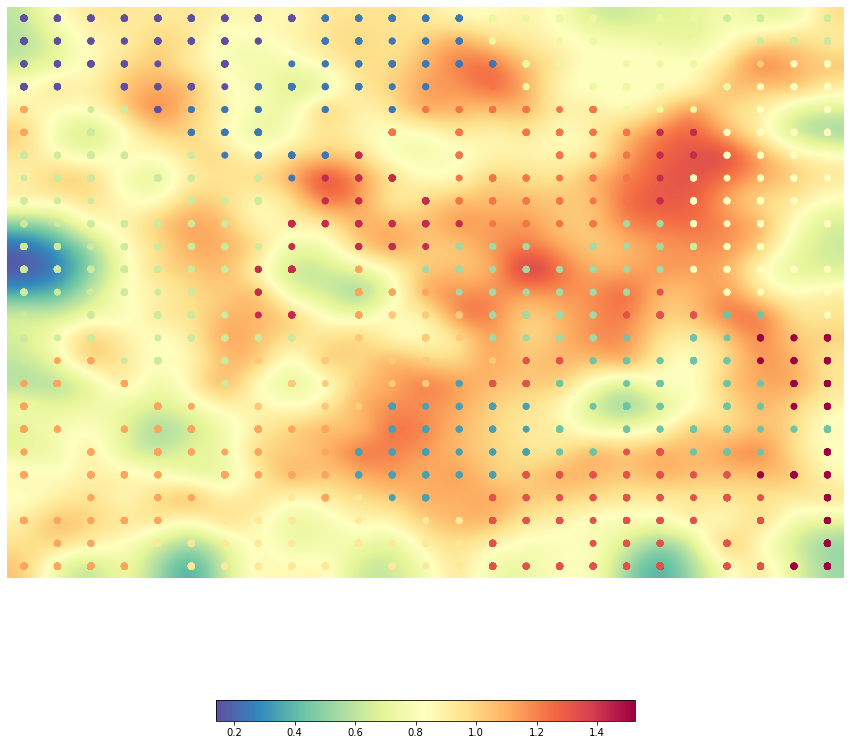

Cluster 0:
All neurons:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 25, 26, 27, 28, 29, 30, 31, 32, 33, 50, 51, 52, 53, 54, 55, 56, 57, 75, 76, 77, 78, 79, 80, 81, 104}
Kept neurons: {0, 1, 2, 3, 4, 5, 6, 7, 8, 25, 26, 27, 28, 31, 32, 33, 50, 51, 52, 54, 55, 56, 57, 75, 76, 77, 78, 79, 81, 104}
Kept 30/34 neurons
Overall Cluster Genres stats:
[('Horror', 175), ('Drama', 161), ('World cinema', 87), ('Musical', 81), ('Bollywood', 39), ('Slasher', 35), ('Science Fiction', 33), ('Black-and-white', 27), ('Documentary', 19), ('Fantasy', 17), ('Short Film', 17), ('Indie', 15), ('Cult', 13), ('Comedy', 12), ('War film', 12), ('Psychological thriller', 11), ('Creature Film', 10), ('Japanese Movies', 10), ('Romance Film', 10), ('Zombie Film', 10), ('Art film', 9), ('Teen', 9), ('Comedy film', 8), ('Crime Fiction', 8), ('Mystery', 8), ('Supernatural', 8), ('Political drama', 7), ('Horror Comedy', 6), ('Melodrama', 6), ('Chinese Movies', 5), ('Family Film', 5), ('Film noir', 5), ('Surrealism', 5), ('Action', 4),

In [ ]:
n_rows = 25
n_columns = 25
clusters_num = 15
epochs = 50

create_and_save_som(n_rows, n_columns, clusters_num, epochs)
load_som(n_rows, n_columns, clusters_num)
check_som(clusters_num, n_columns)

In [ ]:
import joblib
som_252515 = joblib.load('som-25-25-15.pkl')
print(som_252515.clusters)

[[10 10 10 10 10 10 10 10 10  0  0  0  0 12 12 12 12 12  2  2  2  3  3  3
   3]
 [10 10 10 10 10 10 10 10 10  0  0  0  0 12 12 12 12 12  2  2  2  2  3  3
   3]
 [10 10 10 10 10 10 10 10  0  0  0  0  0 12 12 12 12 12  2  2  2  2 11 11
  11]
 [10 10 10 10 10 10 10  0  0  0  0  0  0 12 12 12 12 12  2  2  2  2 11 11
  11]
 [ 1  1  1  1 10  0  0  0  0  0  0  0  0  7  7  7  7  7  2  2  2 11 11 11
  11]
 [ 1  1  1  1  0  0  0  0  0  0  7  7  7  7  7  7  7  7  7  2  2 11 11 11
  11]
 [ 1  1  1  1  3  3  0  0  0  0  7  7  7  7  7  7  7  7  7  7 11 11 11 11
  11]
 [ 1  1  1  3  3  3  3  3  0  0  7  7  7  7  7  7  7  7 14 14 11 11 11 11
  11]
 [ 3  3  3  3  3  3  3  3  3  6  7  7  7  7  7  7  7 14 14 14 11 11 11 11
  11]
 [ 3  3  3  3  3  3  3  3  3  6  6  6  6  6  7  7 14 14 14 14  1 11 11 11
  11]
 [ 3  3  3  3  3  3  3  3  3  6  6  6  6  6  6  6 14 14 14 14  1 11 11 11
  11]
 [ 3  3  3  3  3  3  3  3  3  6  6  6  6  6  6  6 14 14 14  1  1 11 11 11
  11]
 [ 3  3  3  3  3  3  3  3  3  6  6  6  6

Αριθμός νευρώνων ανά cluster

In [ ]:
occurencies = list(enumerate(np.bincount(som_252515.clusters.ravel())))
occurencies.sort(key=lambda pair: pair[1], reverse=True)
print("Cluster \t| #neurons")
print("------------------------")
for pair in occurencies:
  print(f"{pair[0]} \t\t| {pair[1]}")

Cluster 	| #neurons
------------------------
3 		| 83
13 		| 76
9 		| 66
6 		| 47
11 		| 46
7 		| 41
0 		| 39
1 		| 35
8 		| 35
10 		| 34
4 		| 32
5 		| 26
2 		| 25
12 		| 20
14 		| 20




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


**Σημειώνουμε εδώ πως ως αναφορά έχουμε τον τελευταίο χάρτη που παράξαμε δηλαδή 25x25 με 15 clusters.**

### 1

>*Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.*

In [ ]:
cats = list(print_categories_stats([i for i in range(5000)]))
most_popular = cats[0:5]
print(most_popular)
least = cats[-6:-1]
print(least)


[('Drama', 2264), ('Comedy', 1246), ('Romance Film', 801), ('Thriller', 789), ('Action', 742)]
[('Steampunk', 1), ('Therimin music', 1), ('Tokusatsu', 1), ('Vampire movies', 1), ('Werewolf fiction', 1)]


Παρατηρούμε πως στο σύνολο των ταινιών οι πιο συχνές κατηγορίες είναι Drama , Comedy, Romance Film, Thriller και Action. 

* Επίσης παρατηρώντας παραπάνω τα clusters με τους περισσότερους νευρώνες βλέπουμε πως οι κατηγορίες που υπερέχουν στα clusters αυτά είναι σχεδόν πάντα μία από τις top 5 κατηγορίες ταινιών βάσει των δεδομένων εισόδου.

* Αντίστοιχα μη δημοφιλείς κατηγορίες ταινιών δεν εμφανίζονται στην "κορυφή" των clusters και επακολούθως δε καταλμβάνουν πολλούς νευρώνες.



Για παράδειγμα:
* Βλέπουμε πως οι κατηγορίες Drama και Comedy εμφανίζονται πολυ συχνά στην κορυφή της λίστας Overall Cluster Genres Stats για κάθε cluster γεγονός που επιβεβαιώνει τη δημοφιλία τους. 

* Αντίστοιχα, για κατηγορίες όπως Biography, Epic ή History θα πρέπει να κοιτάξουμε στο τέλος αυτών των λιστών.

### 2

>*Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.*



* Παρατηρούμε πως τα clusters 9 και 10 βρίσκονται σε εκ διαμέτρου αντίθετες θέσεις στο χάρτη.
Αυτό ορθώς συμβαίνει αφού οπως βλέπουμε από τα Overall Cluster Genres stats ο cluster 9 έχει ως επικρατέστερη κατηγορία την κατηγορία Comedy ενω ο 10 την κατηγορία Drama.

* Aκόμη ένα παράδειγμα είναι στο αρχικό 10x10 grid όπου οι clusters 7 και 13 είναι τέλειως απομακρυσμένοι αφού ο cluster 7 έχει ως επικρατέστερη την κατηγορία Horror ενώ ο 13 την Romantic Comedy. 

### 3

>*Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.*

* Βλέπουμε πως οι clusters 9 και 4 συνορεύουν αφού επικρατέστερη κατηγορία είναι και στα 2 η Comedy.

* Γειτονικά είναι και τα clusters 5, 13 με το επικρατέστερο είδος να έιναι και στα 2 το Thriller.

* Βλέπουμε πως στο cluster 9(Comedy) γειτονικό είναι και το cluster 5 παρά την επικρατέστερη κατηγορία του που είναι Τhriller καθως οι δευτερεύουσες κατηγορίες του είναι Comedy , Crime Fiction οι οποίες είναι κοινές μεταξύ τους.

>*Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.*
>*Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.* 

Ένα cluster που δεν παρουσιάζει σαφή χαρακτηριστικά είναι το cluster 12 με τις 10 πιο συχνές κατηγορίες να είναι:
* ('Drama', 91), ('Crime Fiction', 80), ('Comedy', 63), ('Black-and-white', 47), ('Indie', 46), ('Thriller', 38), ('Romance Film', 25), ('Silent film', 25), ('Romantic comedy', 23), ('Family Film', 16)...] .

Παρατηρούμε πως δεν υπάρχει σαφής κατηγορία που υπερισχύει και πως οι κατηγορίες που υπερισχύουν δεν έχουν κοινά σημεία μεταξύ τους.

Παρατηρούμε επίσης πως περιτρυγίζεται από τα clusters 0,7 και 2. Αυτό βγάζει νόημα αφού τα clusters έχουνε μεγάλο αριθμό ταινιών από την κατηγορία Drama. \\
Το cluster 0 δε, έχει και αρκετές ταινίες από την κατηγορία World Cinema που δεν είναι κατηγορία που χαρακτηρίζει μία ταινία αλλα πιο γενική που μπορεί να συσχετίζεται με αυτές του cluster 12.

> Πιο γενικά συμπερασμάτα



Γενικά από τα heat maps των τελευταίων ερωτημάτων, παρατηρούμε πως όσο αυξάνεται το grid size και μειώνονται τα clusters τόσο πιο ευδιάκριτα γίνονται τα όρια των clusters (με κόκκινο χρώμα).